### VCF parsing

In [2]:
import os
import re
import pandas as pd
import copy
import itertools
import seaborn as sns

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
class VariantCalls:

    def __init__(self, name):
        self.name = name
        self._calls = None
        self._readable_calls = None

    @ property
    def calls(self):
        return self._calls

    @ calls.setter
    def calls(self, table):
        self._calls = table

    @ calls.deleter
    def calls(self):
        del self._calls

    @ property
    def readable_calls(self):
        return self._readable_calls

    def make_readable(self, columns):

        table = self._calls

        for column in columns:
            match column:
                case "FILTER":
                    table = VariantCalls.by_prefiltering(table)
                case "INFO":
                    table = VariantCalls.by_info_column(table)
                case "FORMAT":
                    table = VariantCalls.by_format_column(table)
                case _:
                    raise ValueError

        self._readable_calls = table

    @ staticmethod
    def by_prefiltering(table: pd.DataFrame, select = "PASS") -> pd.DataFrame:
        # filter passing variants
    
        table = table[table.FILTER == select] 
        table.reset_index(drop=True, inplace=True)

        return table

    @ staticmethod
    def by_info_column(table: pd.DataFrame):
        # make INFO column readable; annotation

        ANNOTATION_COLUMNS = [
                      "Gencode_34_hugoSymbol",
                      "Gencode_34_ncbiBuild",
                      "Gencode_34_chromosome",
                      "Gencode_34_start",
                      "Gencode_34_end",
                      "Gencode_34_variantClassification",
                      "Gencode_34_secondaryVariantClassification",
                      "Gencode_34_variantType"
                      ]

        col = table.INFO.str.split(';', expand=True)
       
        info = col.applymap(lambda x: x.split('=')[-1] if x is not None else None)

        index_label_row = info.isnull() \
                              .sum(axis=1) \
                              .idxmin()

        info.columns = col.iloc[index_label_row,:].apply(lambda x: x.split('=')[0]).to_list()

        functional_annotation = info.FUNCOTATION.apply(lambda x: x[1:].split('|')[:8])
        functional_annotation = pd.DataFrame.from_records(functional_annotation, columns=ANNOTATION_COLUMNS)
        functional_annotation.drop(["Gencode_34_ncbiBuild","Gencode_34_chromosome"], axis=1, inplace=True)

        info.drop(["FUNCOTATION"], axis=1, inplace=True)
        
        info = pd.concat([info, functional_annotation], axis=1)

        table.drop(["INFO"], axis=1, inplace=True)
        table = pd.concat([table, info], axis=1)
       
        return table
        
    @ staticmethod
    def by_format_column(table: pd.DataFrame):
        # make FORMAT and SAMPLE column readable; counts
        
        per_variant = []
        col = table.columns.get_loc("FORMAT")
        feature_columns = range(col, col+3)

        format_columns = table.iloc[:, feature_columns].applymap(lambda x: x.split(':'))
        label, values = format_columns.iloc[:,0].to_list(), format_columns.iloc[:,1].to_list()

        for i in range(table.shape[0]):
            per_variant.append(dict(zip(label[i], values[i])))

        counts = pd.DataFrame(per_variant)

        table.drop(table.columns[feature_columns], axis=1, inplace=True)
        table = pd.concat([table, counts], axis=1)

        return table

    def calculate_variant_allele_frequency(self) -> None:
        # variant allele frequency

        self._readable_calls["VARIANT_ALLELE_FREQ"] = self._readable_calls.AD.apply(lambda x: VariantCalls.helper_get_vaf(x))
  
    @ staticmethod
    def helper_get_vaf(row: str) -> float:

        counts = row.split(',') 
        ref, alt = [int(i) for i in counts]
        
        return alt/(ref+alt)

In [5]:
class Cohort:

    def __init__(self, name, directory):
        self.name = name
        self.directory = directory
        self.cohort_calls = []

    def get_cohort_calls(self) -> None:
        
        variant_call_files = os.listdir(self.directory)
        
        for file in variant_call_files:
            filepath = self.directory + '/' + file
            table = Cohort.load_sample_calls(filepath)
            
            name = re.search(r"case-\d+", file).group()
            
            _ = VariantCalls(name)
            _.calls = table
            _.make_readable(columns=["FILTER","INFO","FORMAT"])
            _.calculate_variant_allele_frequency()
            _.readable_calls

            self.cohort_calls.append(_) 

    @ staticmethod
    def load_sample_calls(file) -> pd.DataFrame:

        with open (file) as fh:
            for i, line in enumerate(fh):
                if not line.startswith("##"):
                    skip_to_line = i
                    break

        calls = pd.read_csv(file, sep="\t", skiprows=skip_to_line)

        return calls

In [6]:
path = "/users/wuchh/downloads/updated-calls"
test = Cohort(name="PEAC", directory="/users/wuchh/downloads/updated-calls")
test.get_cohort_calls()

In [7]:
genes_each = []
for i in range(len(test.cohort_calls)):
    unique_in_sample = test.cohort_calls[i].readable_calls.Gencode_34_hugoSymbol.unique().tolist()
    genes_each.append(unique_in_sample)

In [8]:
merged = list(itertools.chain.from_iterable(genes_each))

In [9]:
data = pd.Series(merged).value_counts()

<AxesSubplot: ylabel='Count'>

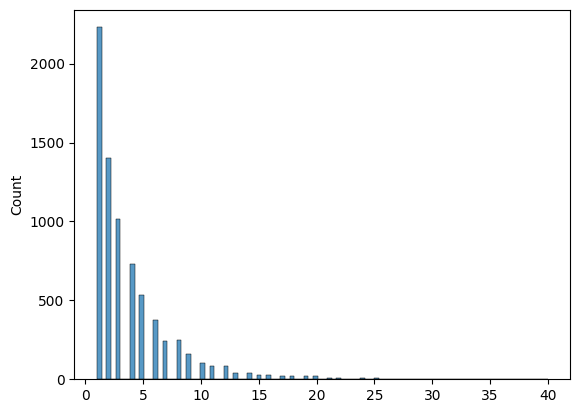

In [14]:
sns.histplot(data)

In [20]:
l = []

In [21]:
for f in range(40):
    a = test.cohort_calls[f].readable_calls[test.cohort_calls[f].readable_calls.Gencode_34_hugoSymbol == "MAVS"].POS
    b= a.tolist()

    l.append(b)
    #if not a.empty:
    #    print(a)

In [ ]:
# not the same site, but within an acceptable window size

In [23]:
merged = list(itertools.chain.from_iterable(l))

In [24]:
merged

[3869290,
 3870961,
 3870574,
 3875359,
 3871064,
 3870985,
 3871064,
 3871142,
 3872291,
 3874502,
 3867451,
 3867481,
 3871103,
 3869097,
 3875197,
 3875200,
 3875295,
 3875359,
 3868801,
 3873484,
 3868519,
 3875359,
 3873413,
 3873459,
 3869083,
 3871068,
 3872413,
 3872420,
 3873320,
 3874502,
 3872206,
 3873276,
 3870567,
 3872358,
 3870955,
 3870985,
 3872420,
 3875295,
 3869840,
 3870567,
 3871115,
 3875197,
 3875200,
 3875301,
 3870961,
 3871120,
 3872184,
 3875295,
 3873277,
 3875295,
 3875335,
 3869685,
 3869866,
 3875197,
 3875200,
 3872184,
 3873459,
 3874502,
 3875295,
 3869814,
 3875197,
 3875295,
 3869052,
 3871064,
 3869666,
 3873324,
 3873347,
 3875232,
 3869866,
 3875295,
 3870544,
 3870567,
 3873376,
 3875197,
 3869785,
 3870762,
 3871007,
 3871010,
 3871144,
 3875295,
 3869734,
 3871010,
 3872185,
 3872207,
 3872277,
 3871143,
 3875232]

<AxesSubplot: >

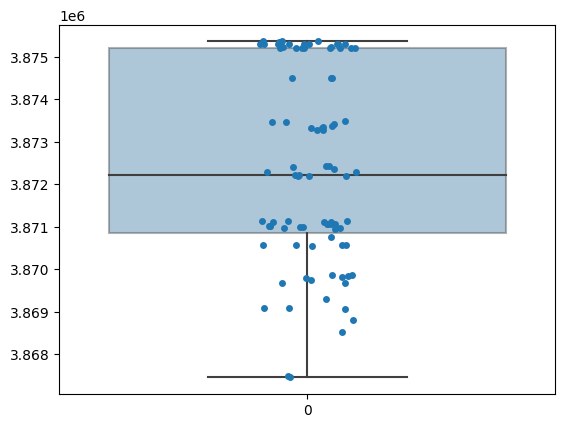

In [28]:
sns.boxplot(merged, boxprops={'alpha': 0.4})
sns.stripplot(merged)
# color by sample

<AxesSubplot: >

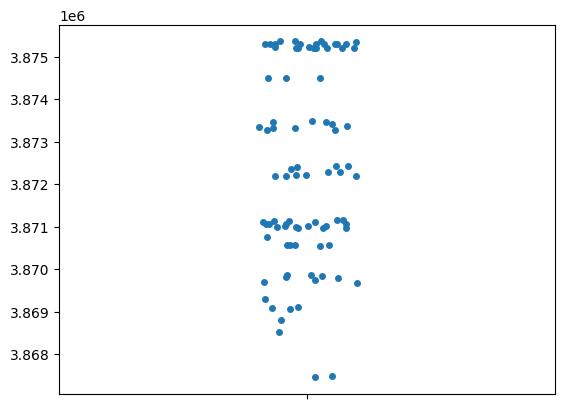

In [27]:
sns.stripplot(merged)
# color by sample

In [ ]:
# window
# chi-square (has or does not have mutation, with category of interest)
# regression 
# dN/dS

# underlying assumption that (1) early in RA there has not been sufficent time to acquire mutations (2) exact point mutations are not needed, just overlapping in window (degenerate binding interactions, etc)